In [7]:
# Install necessary packages if not already installed
!pip install scikit-learn pandas matplotlib seaborn joblib --quiet

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib

In [8]:
# Load data
file_path = "/content/oversampled_cities.csv"
df = pd.read_csv(file_path)

# Features and target
features = ['PM2.5', 'PM10', 'NO', 'NO2', 'NOx', 'NH3', 'CO', 'SO2', 'O3', 'Benzene', 'Toluene']
target = 'AQI'

# Drop missing values and scale
df = df.dropna(subset=features + [target])
X = df[features].values
y = df[target].values
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [9]:
# Hyperparameter grid
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 20, 30],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

In [10]:
# K-Fold CV
kf = KFold(n_splits=7, shuffle=True, random_state=42)
mae_list, rmse_list, r2_list = [], [], []
all_preds, all_acts = [], []
best_params_list = []
fold = 1

print("🔄 Starting K-Fold Training and Tuning...")

for train_idx, val_idx in kf.split(X):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Hyperparameter tuning with GridSearchCV
    base_model = RandomForestRegressor(random_state=42)
    grid = GridSearchCV(base_model, param_grid, cv=3, n_jobs=-1, scoring='r2')
    grid.fit(X_train, y_train)

    best_model = grid.best_estimator_
    best_params_list.append(grid.best_params_)

    y_pred = best_model.predict(X_val)
    all_preds.append(y_pred)
    all_acts.append(y_val)

    # Metrics
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)

    mae_list.append(mae)
    rmse_list.append(rmse)
    r2_list.append(r2)

    print(f"Fold {fold} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}")
    fold += 1

# Overall metrics
print("\n✅ K-Fold Cross-Validation Results:")
print(f"Average MAE: {np.mean(mae_list):.2f}")
print(f"Average RMSE: {np.mean(rmse_list):.2f}")
print(f"Average R²: {np.mean(r2_list):.4f}")

# Most common best parameters
from collections import Counter
param_counts = Counter(tuple(sorted(p.items())) for p in best_params_list)
best_params = dict(sorted(param_counts.most_common(1)[0][0]))
print("\n🔥 Most Frequent Best Parameters:")
print(best_params)

🔄 Starting K-Fold Training and Tuning...
Fold 1 - MAE: 10.66, RMSE: 18.85, R²: 0.9561
Fold 2 - MAE: 11.05, RMSE: 19.09, R²: 0.9577
Fold 3 - MAE: 10.92, RMSE: 19.16, R²: 0.9566
Fold 4 - MAE: 10.35, RMSE: 17.63, R²: 0.9632
Fold 5 - MAE: 11.10, RMSE: 19.44, R²: 0.9564
Fold 6 - MAE: 10.74, RMSE: 18.92, R²: 0.9532
Fold 7 - MAE: 11.57, RMSE: 20.77, R²: 0.9478

✅ K-Fold Cross-Validation Results:
Average MAE: 10.91
Average RMSE: 19.12
Average R²: 0.9559

🔥 Most Frequent Best Parameters:
{'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [11]:
# Final train-test split for validation
X_train_final, X_test_final, y_train_final, y_test_final = train_test_split(
    X, y, test_size=0.2, random_state=42)

# Final model training on 80% data
final_model = RandomForestRegressor(random_state=42, **best_params)
final_model.fit(X_train_final, y_train_final)

# Final evaluation on 20% holdout
y_test_pred = final_model.predict(X_test_final)
final_mae = mean_absolute_error(y_test_final, y_test_pred)
final_rmse = np.sqrt(mean_squared_error(y_test_final, y_test_pred))
final_r2 = r2_score(y_test_final, y_test_pred)

print("\n✅ Final Evaluation on Hold-Out Set:")
print(f"Final MAE: {final_mae:.2f}")
print(f"Final RMSE: {final_rmse:.2f}")
print(f"Final R²: {final_r2:.4f}")

# Save model and scaler
joblib.dump(final_model, "rf_bestest_model.pkl")
joblib.dump(scaler, "rf_bestest_scaler.pkl")


✅ Final Evaluation on Hold-Out Set:
Final MAE: 10.77
Final RMSE: 18.24
Final R²: 0.9595


['rf_bestest_scaler.pkl']

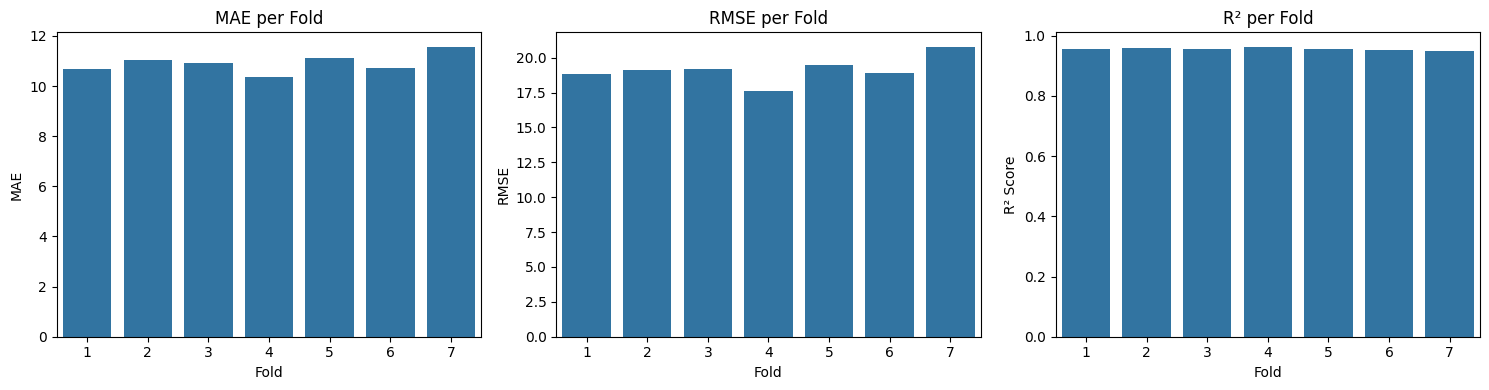

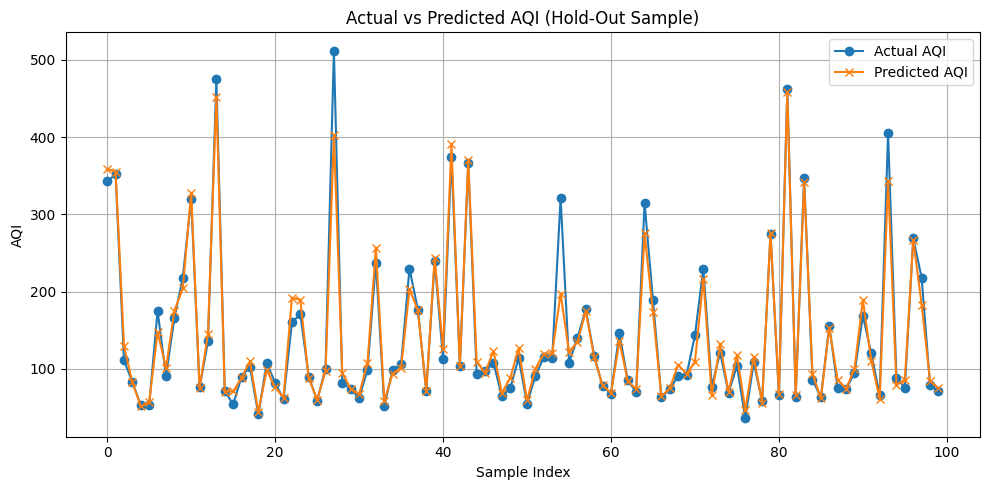

/tmp/ipython-input-12-2275640742.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')


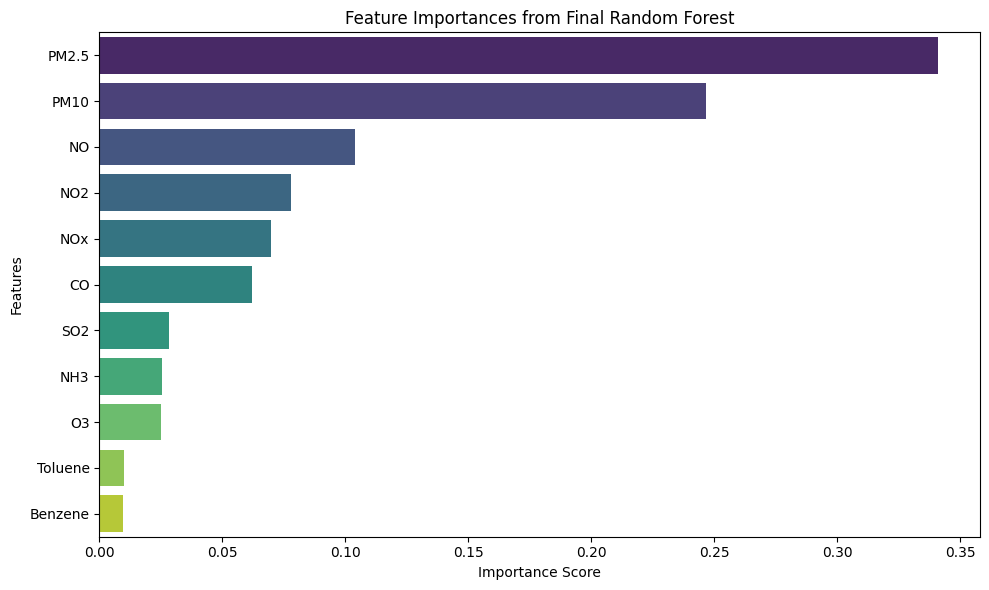


📦 Model and scaler saved as 'rf_best_model.pkl' and 'rf_best_scaler.pkl'.


In [12]:
# ---------------- VISUALIZATIONS ----------------

# Bar plots for CV metrics
folds = list(range(1, 8))
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
sns.barplot(x=folds, y=mae_list)
plt.title("MAE per Fold")
plt.xlabel("Fold")
plt.ylabel("MAE")

plt.subplot(1, 3, 2)
sns.barplot(x=folds, y=rmse_list)
plt.title("RMSE per Fold")
plt.xlabel("Fold")
plt.ylabel("RMSE")

plt.subplot(1, 3, 3)
sns.barplot(x=folds, y=r2_list)
plt.title("R² per Fold")
plt.xlabel("Fold")
plt.ylabel("R² Score")

plt.tight_layout()
plt.show()

# Actual vs Predicted for hold-out
plt.figure(figsize=(10, 5))
plt.plot(y_test_final[:100], label="Actual AQI", marker='o')
plt.plot(y_test_pred[:100], label="Predicted AQI", marker='x')
plt.title("Actual vs Predicted AQI (Hold-Out Sample)")
plt.xlabel("Sample Index")
plt.ylabel("AQI")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Feature importance
importances = final_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df, palette='viridis')
plt.title("Feature Importances from Final Random Forest")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

print("\n📦 Model and scaler saved as 'rf_best_model.pkl' and 'rf_best_scaler.pkl'.")